In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import xgboost as xgb
import pickle
from mpl import cross_valid
from mpl import estimation
from sklearn import metrics
from sklearn import model_selection


In [2]:
itch_dt = pd.read_csv('data/ericson_data.csv')
itch_dt = itch_dt.rename(columns={"Subject":"person_id",
                        "Condition":"condition",
                        "Question":"question_id",
                        "X1":"ss_x",
                        "T1":"ss_t",
                        "X2":"ll_x",
                        "T2":"ll_t",
                        "LaterOptionChosen": "choice"}).drop(['R','G','D'],axis=1)


dataset = cross_valid.generate_sample(itch_dt)


features = ['ss_x', 'ss_t', 'll_x', 'll_t','abs_diff_x', 'abs_diff_t', 
                   'rel_diff_x','rel_diff_t','growth_x']
label = ['choice']


X = dataset[features]
y = dataset[label]
groups = dataset['person_id']

train_index,test_index = list(model_selection.GroupShuffleSplit(n_splits=1,train_size=.8,random_state=2023).
                              split(X,y,groups))[0]

train_sample = dataset[dataset.index.isin(train_index)]
test_sample = dataset[dataset.index.isin(test_index)]

sgkf = model_selection.StratifiedGroupKFold(n_splits=5,shuffle=True,random_state=2023)

cv = list(sgkf.split(X=train_sample[features],
                y=train_sample[label],
                groups=train_sample['person_id']))

In [31]:
param_grid = {'n_estimators': [40],
              'max_depth': [3],
              'learning_rate': [.1],
              'gamma': [.3],
              'reg_lambda': [.7],
              'subsample': [.55],
              'colsample_bytree': [1.0]
            }

model = xgb.XGBClassifier(objective='binary:logistic')

grid_search = model_selection.GridSearchCV(model, param_grid, cv=cv, 
                                           scoring="neg_log_loss", refit="neg_log_loss",
                                           n_jobs=-1,verbose=3)

grid_search.fit(X=train_sample[features], 
                y=train_sample[label], 
                groups=train_sample['person_id'])

# model = xgb.XGBClassifier(objective='binary:logistic',
#                           max_depth=3,
#                           learning_rate=.1,
#                           gamma=.3,
#                           reg_lambda=.7,
#                           subsample=.6,
#                           colsample_bytree=1.0,
#                           eval_metric=['error','logloss'],
#                           early_stopping_rounds=30)
# eval_set = [(X_train, y_train), (X_test, y_test)]
# bst = model.fit(X=X_train,
#                 y=y_train,
#                 eval_set=eval_set,
#                 verbose=True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=[(array([    0,     1,     2, ..., 18182, 18183, 18184]),
                  array([   25,    26,    27, ..., 18127, 18128, 18129])),
                 (array([    0,     1,     2, ..., 18182, 18183, 18184]),
                  array([   99,   100,   101, ..., 18151, 18152, 18153])),
                 (array([    0,     1,     2, ..., 18182, 18183, 18184]),
                  array([  167,   168,   169, ..., 18029, 18030, 18031])),
                 (array([    0,     1,     2, ..., 18182, 18183, 18184]),
                  array([  117,   118,   119, ..., 18176, 18177, 18178])),
                 (array([   2...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [1.0], 'gamma': [0.3],
                         'learning_rate': [0.1], 'max_depth': [3],
                         'n_estimators': [40], 'reg_lambda': [0.7],
                         'subsample': [0.55]},
             refit='neg_log_loss', scoring='neg_log_loss', verbose=3)

Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 40, 'reg_lambda': 0.7, 'subsample': 0.55}
Best score: -0.5810776914186546


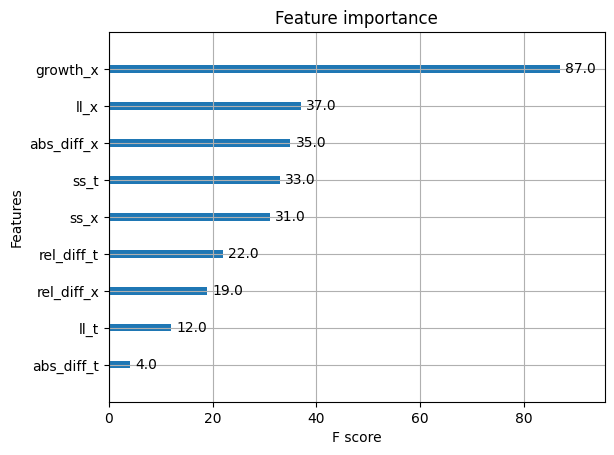

In [32]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")
bst_model = grid_search.best_estimator_
xgb.plot_importance(bst_model)
with open('my_model.pkl', 'wb') as f:
    pickle.dump(bst_model, f)

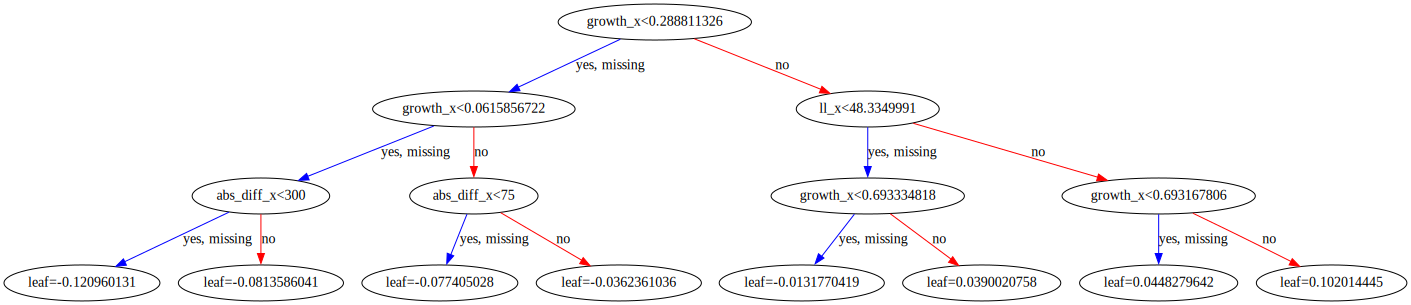

In [33]:
xgb.to_graphviz(bst_model, num_trees=1)

In [14]:
mouse_dt = pd.read_csv('data/reeck_data.csv')
mouse_dt['choice'] = mouse_dt['choice'].replace({'ll':1,'ss':0})
mouse_dt = mouse_dt.rename(columns={"serial":"person_id",
                        "itc_no":"question_id",
                        "accel_delay":"condition",
                        "Cluster":"search_strategy",
                        "ss_amt_val":"ss_x",
                        "ss_time":"ss_t",
                        "ll_amt_val":"ll_x",
                        "ll_time":"ll_t"}).\
                    drop(['unique_itc','ss_delay_type'],axis=1)


mouse_dt['ss_t'] = mouse_dt['ss_t'].str[0]
mouse_dt['ll_t'] = mouse_dt['ll_t'].str[0]
mouse_dt[['ss_x','ss_t','ll_x','ll_t']] = mouse_dt[['ss_x','ss_t','ll_x','ll_t']].astype(float)

cross_valid.generate_sample(mouse_dt)


,person_id,condition,search_strategy,choice,total_time_ms,looktime_index,mean_payne,payne_ind,ll_t,ss_t,ll_x,ss_x,question_id,ratio_x,abs_diff_x,abs_diff_t,rel_diff_x,rel_diff_t,growth_x
0,128912,accel,Comparative,0,5646,-0.106924,-0.165693,1.000000,4.0,2.0,55.8,53.1,1,1.050847,2.7,2.0,0.049587,0.666667,0.024798
1,128912,accel,Comparative,0,5078,0.020807,-0.165693,1.000000,6.0,2.0,22.2,18.5,2,1.200000,3.7,4.0,0.181818,1.000000,0.045580
2,128912,accel,Comparative,1,7813,0.051847,-0.165693,1.000000,2.0,0.0,58.7,43.5,3,1.349425,15.2,2.0,0.297456,2.000000,0.149839
3,128912,accel,Comparative,0,5386,-0.064586,-0.165693,1.000000,4.0,0.0,27.2,24.7,4,1.101215,2.5,4.0,0.096339,2.000000,0.024103
4,128912,accel,Comparative,0,6528,0.099613,-0.165693,0.500000,4.0,0.0,72.1,57.7,5,1.249567,14.4,4.0,0.221880,2.000000,0.055699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6895,132143,delay,Integrative,0,2993,0.082418,1.055501,1.000000,6.0,2.0,34.3,33.3,13,1.030030,1.0,4.0,0.029586,1.000000,0.007397
6896,132143,delay,Integrative,0,6702,0.182088,1.055501,0.714286,2.0,0.0,42.9,42.5,15,1.009412,0.4,2.0,0.009368,2.000000,0.004684
6897,132143,delay,Integrative,1,11494,0.094057,1.055501,1.000000,6.0,2.0,57.1,51.9,16,1.100193,5.2,4.0,0.095413,1.000000,0.023871
6898,132143,delay,Integrative,1,4732,0.066445,1.055501,1.000000,6.0,2.0,75.9,56.2,10,1.350534,19.7,4.0,0.298259,1.000000,0.075125


In [35]:
with open('my_model.pkl', 'rb') as f:
    heuristic_model = pickle.load(f)

preds = heuristic_model.predict(test_sample[features])
trues = test_sample[label]

pred_binary = (preds > .5)

print(f"MSE: {metrics.mean_squared_error(trues, preds)}")
print(f"MAE:{metrics.mean_absolute_error(trues, preds)}")
print(f"log_loss:{metrics.log_loss(trues, preds)}")
print(f"accuracy:{metrics.accuracy_score(trues, pred_binary)}")
print(f"pred_ll:{sum(pred_binary)/len(pred_binary)}")

MSE: 0.29965080750763856
MAE:0.29965080750763856
log_loss:10.349644658041443
accuracy:0.7003491924923614
pred_ll:0.26473155827149714


In [58]:
style = {'dstyle':"trade",'ustyle':'power','method':"logit",'intercept':False}
train_result = estimation.mle(style=style,data=train_sample,disp_output=False)

In [59]:
np.array(train_result['params'])

array([0.356, 0.874, 0.005, 2.893, 0.43 , 4.257])

In [60]:
cross_valid.test_model(style=style,test_sample=test_sample,params=train_result["params"])


{'mse': 0.2167653625171046,
 'mae': 0.4319054882444174,
 'log_loss': 0.6240517594595668,
 'accuracy': 0.6628109995635094,
 'pred_ll': 0.11938018332605849}

In [78]:
aux_sample = itch_dt[itch_dt.index.isin(np.random.choice(itch_dt.index,size=1000,replace=False))][['ss_x','ss_t','ll_x','ll_t']]
aux_sample = cross_valid.generate_sample(aux_sample)
aux_sample['choice'] = heuristic_model.predict(aux_sample[features])
cross_valid.test_model(style=style,test_sample=aux_sample,params=train_result["params"])

In [120]:
dstyle_list = list(estimation.config_param['discount_func'].keys())
ustyle_list = list(estimation.config_param['utility_func'].keys())
style_list = [{"dstyle":dstyle_list[i],
               "ustyle":ustyle_list[j],
               "method":'logit',
               "intercept":False} 
              for i in range(len(dstyle_list)) for j in range(len(ustyle_list))]

kf = cross_valid.KFvalidation(style=style_list,data=train_sample,cv=cv,n_jobs=4)

kf.summary().to_csv("kf_result_logit.csv",index=False)

100%|██████████| 110/110 [12:43<00:00,  6.94s/it]
e:\Attention_discounting\attention_discount_project\model\mpl\cross_valid.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.fails = (np.array(self.val_params) == estimation.config_param['msg']['fail_converge'])
d:\Python\lib\site-packages\numpy\core\_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


TypeError: can only concatenate list (not "str") to list

In [124]:
np.where(kf.fails==True)

(array([56, 59, 66], dtype=int64),)

In [129]:
kf.val_styles[66]

{'dstyle': 'quasihb_fc',
 'ustyle': 'cara',
 'method': 'logit',
 'intercept': False}

In [137]:
import itertools
n_style = len(style_list)
n_cv = len(cv)

fit_list = list(itertools.product(np.arange(n_style), np.arange(n_cv)))
fit_list[59]

(11, 4)

In [135]:
style_list[11]

{'dstyle': 'quasihb', 'ustyle': 'cara', 'method': 'logit', 'intercept': False}

In [138]:
train_set = train_sample[train_sample.index.isin(cv[4][0])]
estimation.mle(style=style_list[11],data=train_set)

{'model': 'quasihb-cara',
 'params': [0.999, 0.589, 4.807, 0.716],
 'se': [0.011, 0.02, 0.009, 0.011],
 'gradient': [-0.004, -0.01, 0.0, 0.002],
 'log_loss': 0.651,
 'aic': 15308.988,
 'bic': 15375.961}